In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import varsig as vs

Define Constants
---

In [2]:
min_depth = 100; clonality = (0, 0.4); notation = 'pyrimidine'

EG10fasta_file = '/home/clint/essigmann_analysis/afb1_signature/data/EG10_corrected.fasta'
merfile = '/home/clint/essigmann_analysis/afb1_signature/data/EG10_slice_counts.jf'

Read in Trinucleotide Frequencies of Reference Genome
---

In [3]:
from jellywrap import Jellyfish, dna_notation

j = Jellyfish()
_ = j.read_mer_file(merfile)

Parse all Files
---

In [4]:
from siglib.mutpos import from_mutpos

results = {}
for age in vs._data_m.keys():
    for treatment in sorted(data_m[age].keys()):
        results[str(age) + ' week ' + treatment] = {}
        for id, infile in sorted(data_m[age][treatment].items()):
            print('Sample: {}'.format(id))
            mutations = from_mutpos(infile, EG10fasta_file, clonality=clonality,
                                    notation=notation, min_depth=min_depth, verbose=True)
            results[str(age) + ' week ' + treatment][id] = mutations

Sample: 1798
Found 50 Mutations
Sample: 3497-1440L
Found 65 Mutations
Sample: 3497-1483L
Found 50 Mutations
Sample: 3497-1488L
Found 59 Mutations
Sample: 6210
Found 1713 Mutations
Sample: 6211
Found 1699 Mutations
Sample: 6212
Found 51 Mutations
Sample: 6213
Found 2758 Mutations
Sample: 1795
Found 43 Mutations
Sample: 3494-1440L
Found 15 Mutations
Sample: 3494-1483L
Found 17 Mutations
Sample: 3494-1488L
Found 46 Mutations
Sample: 4510
Found 324 Mutations
Sample: 4511
Found 216 Mutations
Sample: 1642
Found 148 Mutations
Sample: 1643
Found 98 Mutations
Sample: 1644
Found 192 Mutations
Sample: 8114
Found 366 Mutations
Sample: 1639
Found 9 Mutations
Sample: 1640
Found 11 Mutations
Sample: 1641
Found 6 Mutations
Sample: 4508
Found 279 Mutations
Sample: 4509
Found 1134 Mutations
Sample: 8113
Found 227 Mutations


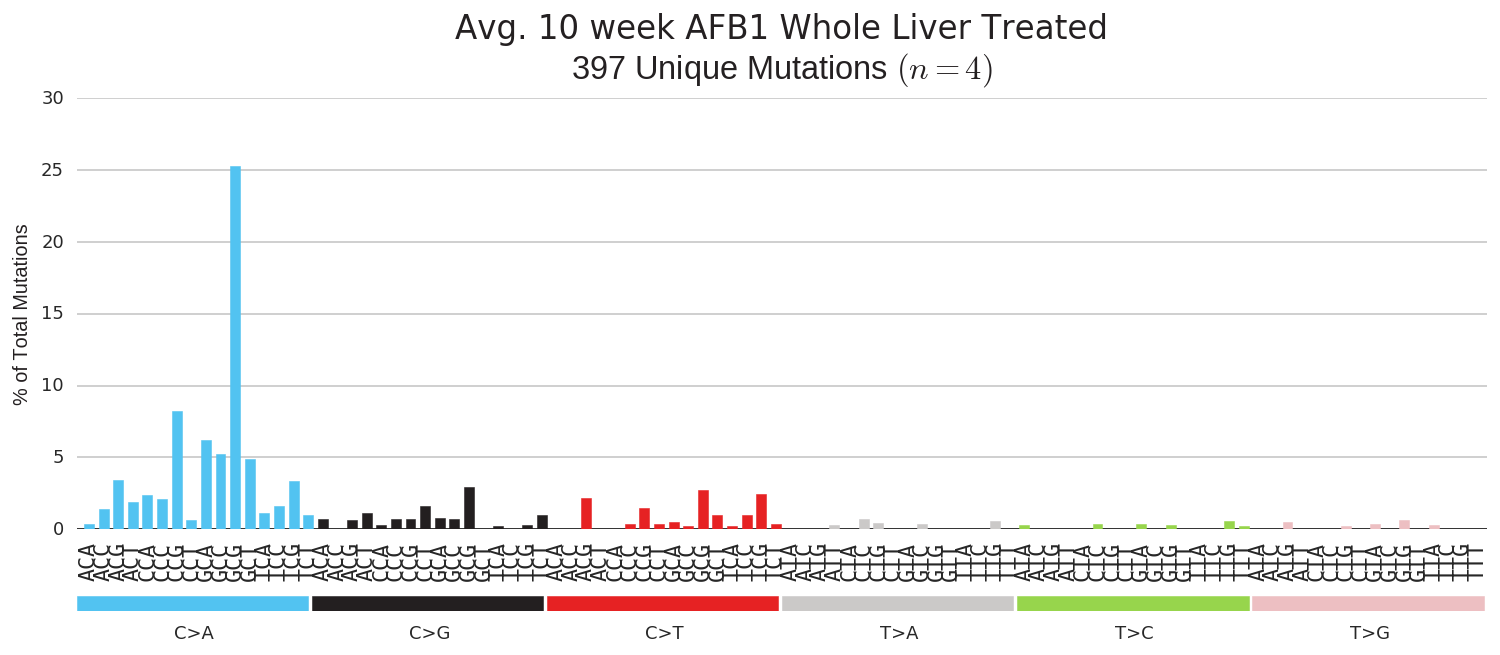

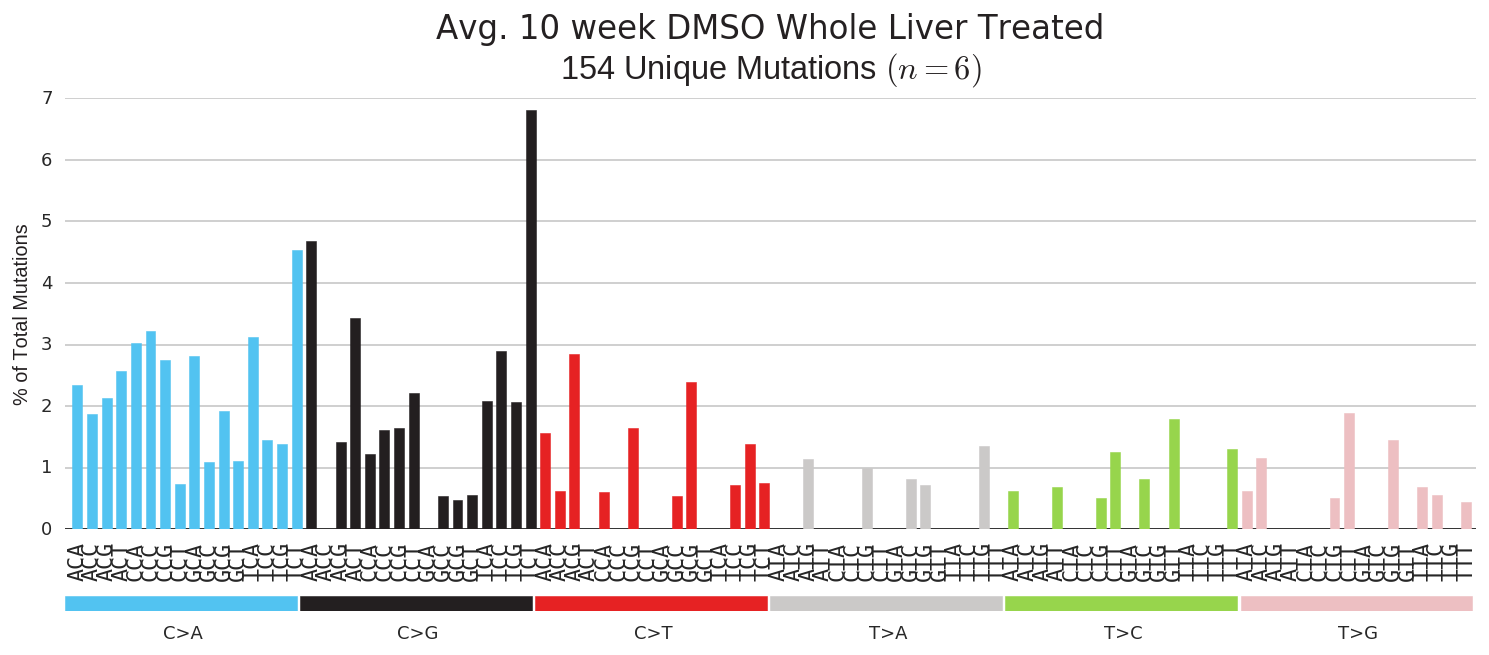

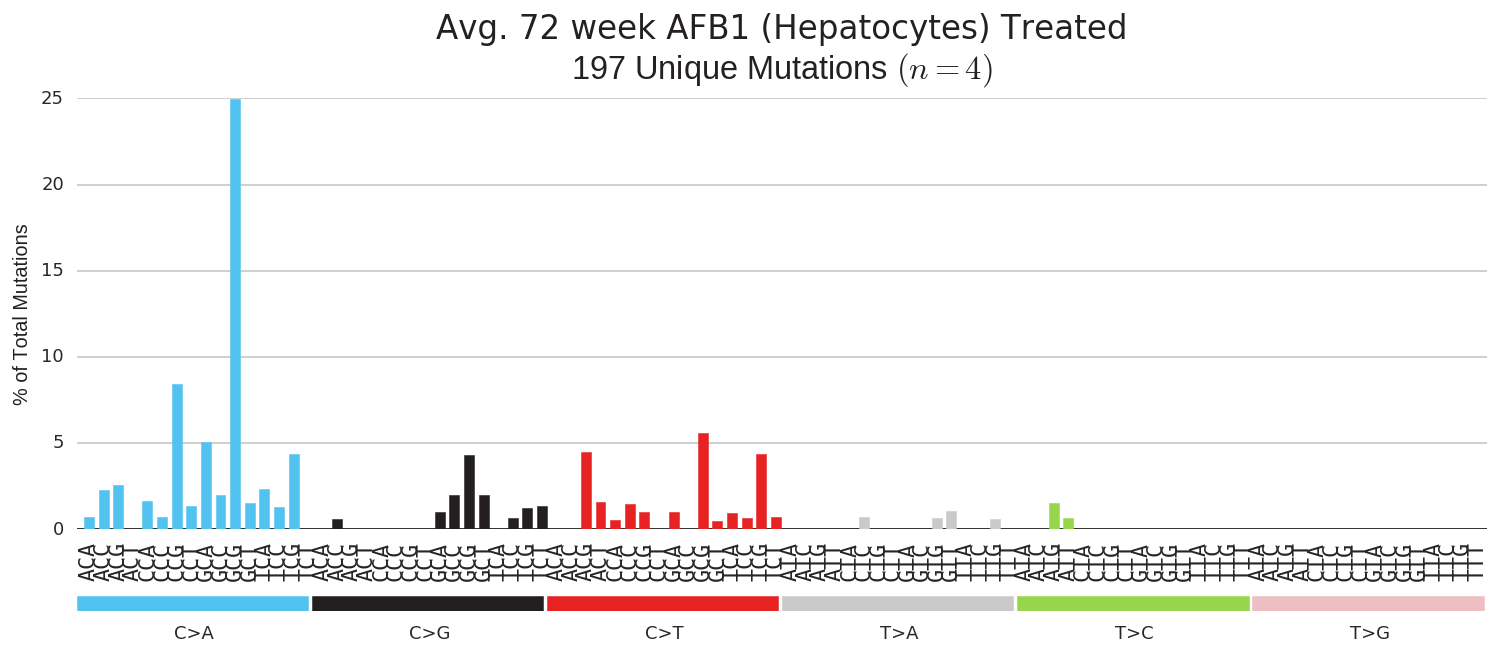

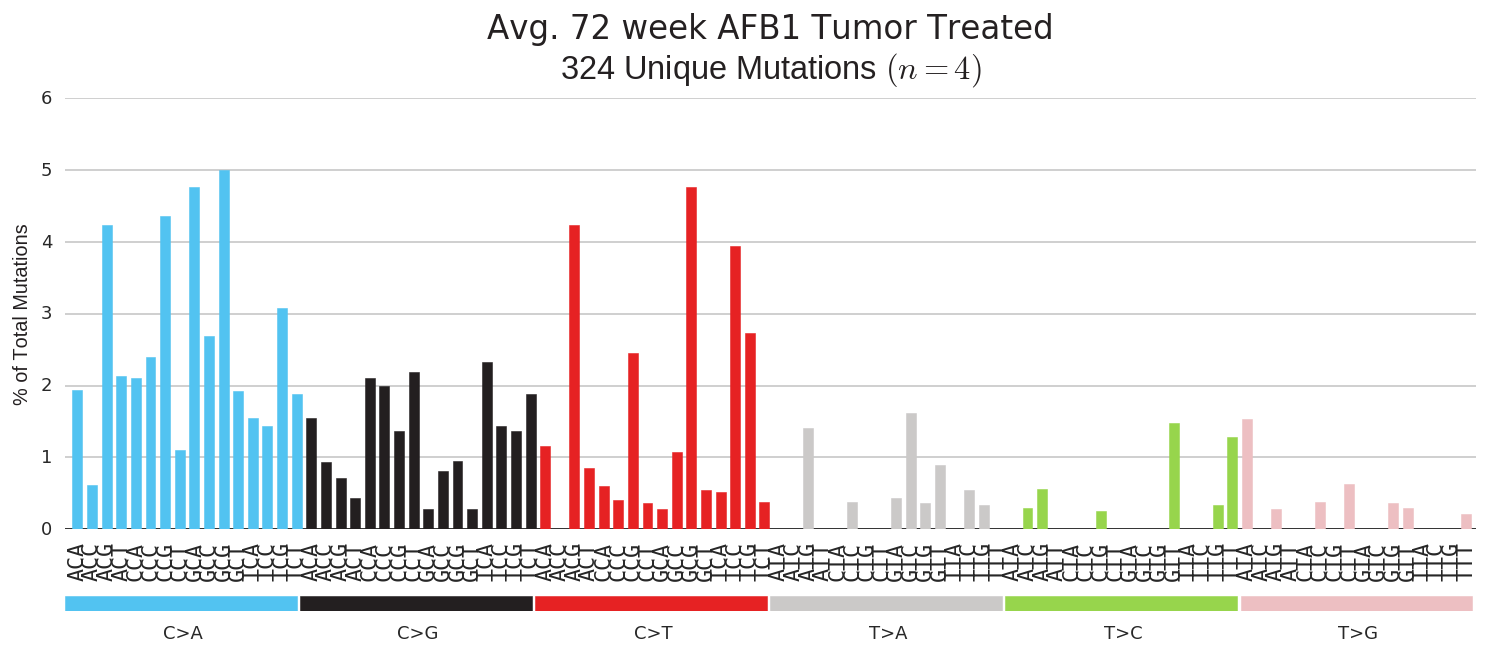

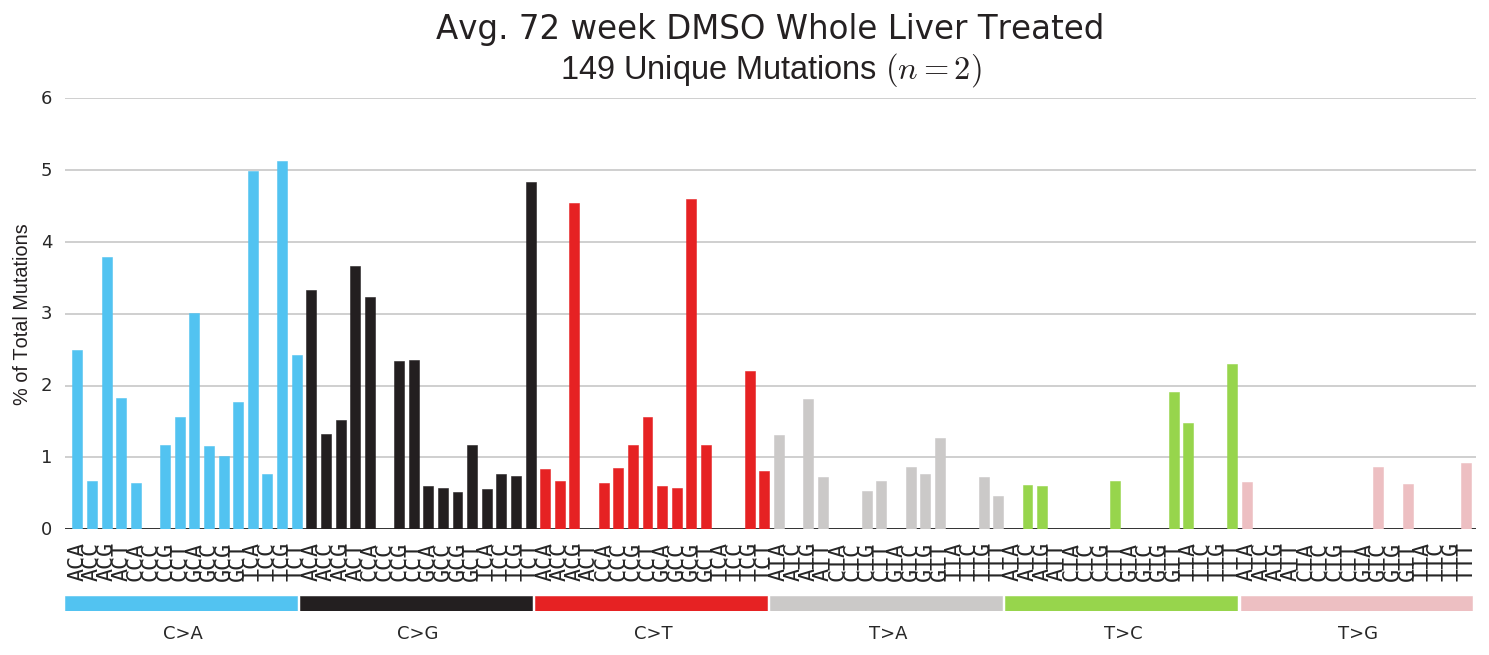

In [12]:
from siglib.utils import Spectrum
from siglib.figures import spectrum_map
names, vectors = [], []

for treatment in sorted(results.keys()):
    if treatment == '72 week DMSO (Hepatocytes)':
        continue

    samples = 0
    full_sum = Spectrum(notation=notation)
    for id, mutations in results[treatment].items():
        samples += 1
        for mutation in set(mutations):
            full_sum[str(mutation.substitution), str(mutation.context)] += 1

    title = 'Avg. {} Treated\n{} Unique Mutations $(n={})$\n\n'.format(treatment, full_sum.variant_total, samples)
    names.append(treatment)
    vectors.append(full_sum.normalized_proportion(j.normal()))
    spectrum_map(x=1, y=1,
                 heights=[[x * 100 for x in full_sum.normalized_proportion(j.normal())]],
                 xlabels=[full_sum.contexts],
                 labels=sorted(set(full_sum.sub_types)),
                 titles=[title])

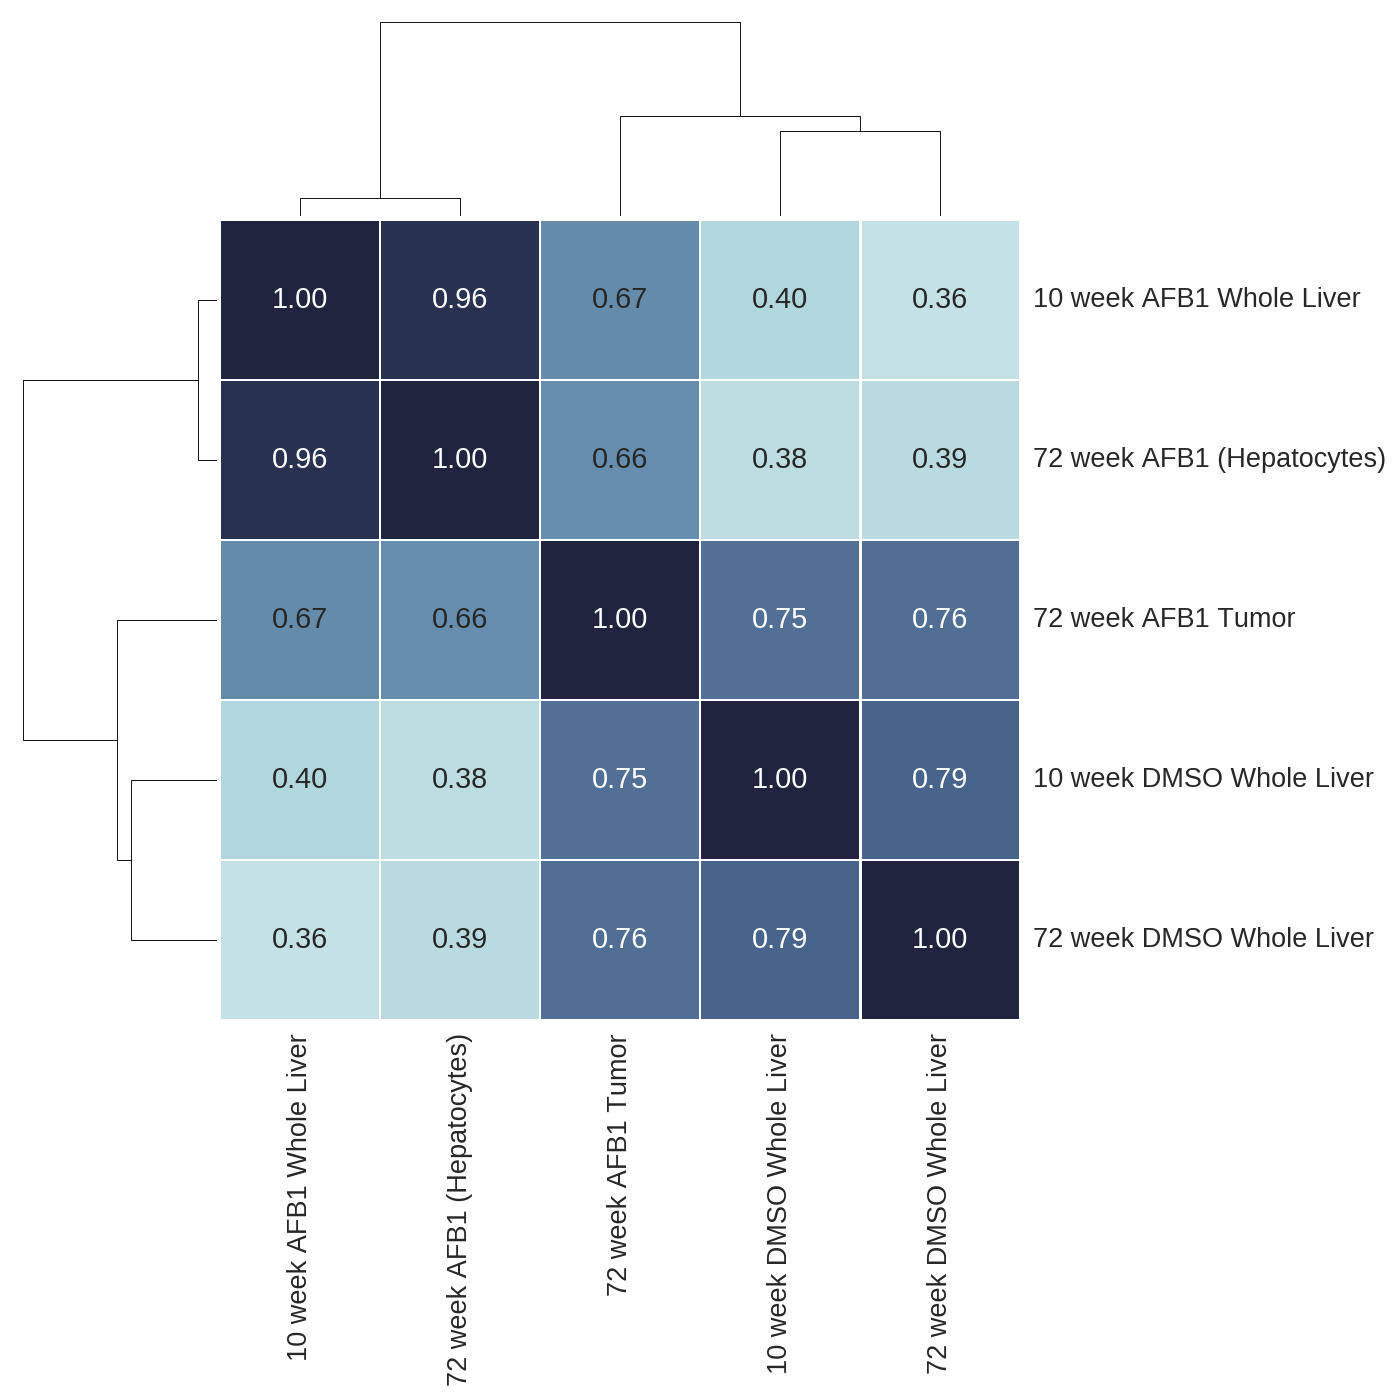

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib

pdist = cosine_similarity(vectors)

distances = pd.DataFrame(pdist, columns=names, index=names)
linkages = linkage(vectors, method='weighted', metric='cosine')

grid = sns.clustermap(distances,
                      fmt='.2f',
                      method='weighted',
                      cmap=sns.cubehelix_palette(start=9, rot=-0.2, dark=0.15, light=.85, as_cmap=True),
                      annot=True,
                      row_linkage=linkages,
                      col_linkage=linkages,
                      row_cluster=True,
                      col_cluster=True,
                      linewidths=.8)

size = 15
_ = grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), size=size)
_ = grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), size=size, rotation=0)
grid.cax.remove()
for t in grid.ax_heatmap.texts:
    t.set_fontsize(16)
for l in grid.ax_row_dendrogram.lines:
        l.set_linewidth(10)
for l in grid.ax_col_dendrogram.lines:
        l.set_linewidth(100)
plt.savefig('cluster.pdf', dpi=450, bbox_inches='tight')